In [2]:
import numpy as np
import pandas as pd
from transformers import LayoutLMForTokenClassification, LayoutLMTokenizer
from PIL import Image, ImageDraw, ImageFont
import torch
from torch import nn

In [3]:
# ! curl https://guillaumejaume.github.io/FUNSD/dataset.zip
# ! unzip dataset.zip && mv dataset data

In [22]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model = LayoutLMForTokenClassification.from_pretrained("microsoft/layoutlm-base-uncased", num_labels=4)
model.to(device)

Some weights of the model checkpoint at microsoft/layoutlm-base-uncased were not used when initializing LayoutLMForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing LayoutLMForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing LayoutLMForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of LayoutLMForTokenClassification were not initialized from the model checkpoint at microsoft

LayoutLMForTokenClassification(
  (layoutlm): LayoutLMModel(
    (embeddings): LayoutLMEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (x_position_embeddings): Embedding(1024, 768)
      (y_position_embeddings): Embedding(1024, 768)
      (h_position_embeddings): Embedding(1024, 768)
      (w_position_embeddings): Embedding(1024, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): LayoutLMEncoder(
      (layer): ModuleList(
        (0): LayoutLMLayer(
          (attention): LayoutLMAttention(
            (self): LayoutLMSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
         

In [ ]:
model

In [4]:
tokenizer = LayoutLMTokenizer.from_pretrained("microsoft/layoutlm-base-uncased")
print(tokenizer.pad_token, tokenizer.pad_token_id)
print(tokenizer.sep_token, tokenizer.sep_token_id)
print(tokenizer.cls_token, tokenizer.cls_token_id)

[PAD] 0
[SEP] 102
[CLS] 101


In [41]:
# drawing utility
image_path = r"C:\Users\parth.shastri.AD1\PycharmProjects\DocExtraction\data\Form_16_jpeg\finance_doc_1.jpg"
annotation = r"C:\Users\parth.shastri.AD1\PycharmProjects\DocExtraction\data\annotations\ocr_anno_finance_doc_1.jpg.csv"
ann_df = pd.read_csv(annotation)
box_cols = ["left", "top", "width", "height"]

coords = ann_df[box_cols]
ann_boxes = []
for idx, row in coords.iterrows():
    x, y, w, h = tuple(row)
    ann_boxes.append([x, y, x+w, y+h])

img = Image.open(image_path).convert("RGB")

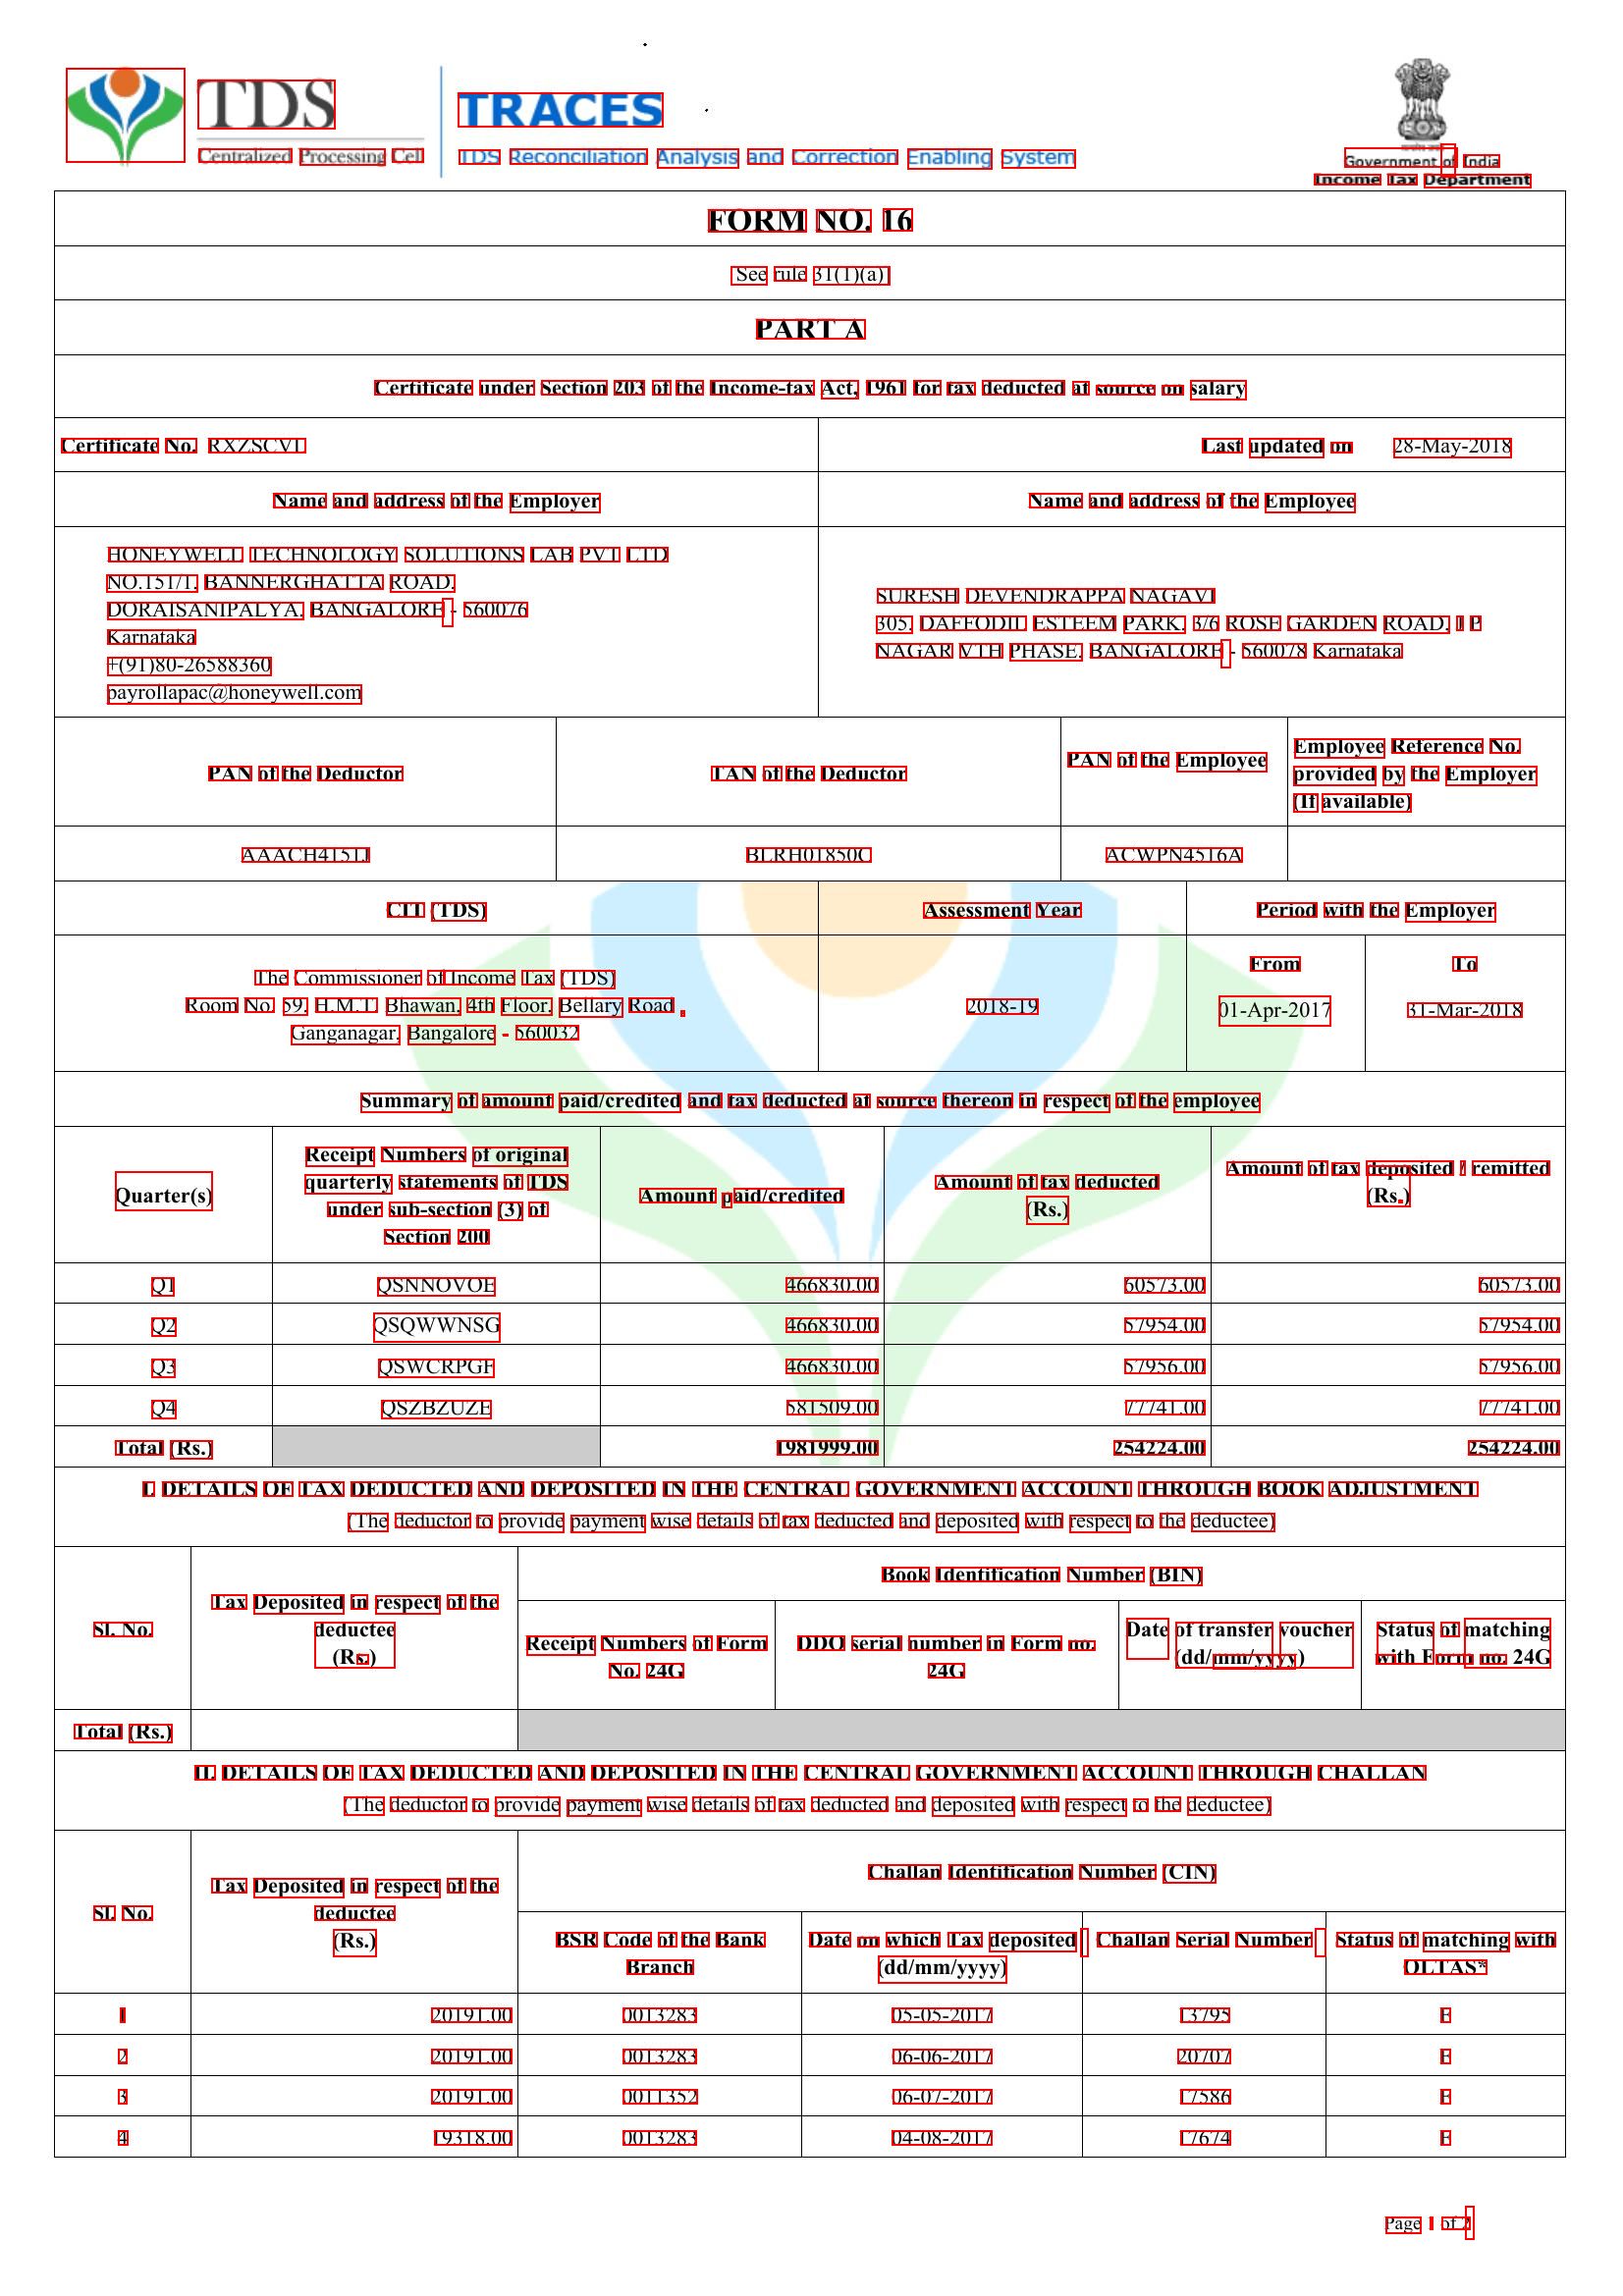

In [42]:

drawer = ImageDraw.Draw(img, "RGBA")
font = ImageFont.load_default()

for box in ann_boxes:
    drawer.rectangle(box, width=2, outline="red")

img

In [18]:
from torch.utils.data import Dataset, DataLoader
import glob
import os
import json

label_list = ["question", "answer", "header", "other"]

class DocParsingDataset(Dataset):
    def __init__(self, image_path, anno_path, tokenizer, max_length, pad_label_id, ann_type="json"):
        super(DocParsingDataset, self).__init__()
        self.image_path = image_path
        self.anno_path = anno_path
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.ann_type = ann_type
        self.pad_label_id = pad_label_id
        if ann_type=="json":
            self.anno_filenames = glob.glob(os.path.join(self.anno_path, "*.json"))
        elif ann_type=="csv":
            self.anno_filenames = glob.glob(os.path.join(self.anno_path, "*.csv"))
        else:
            raise NotImplementedError("Pass either ""json"", or ""csv""")

        self.image_names = glob.glob(os.path.join(self.image_path, "*.png"))

    def __len__(self):
        return len(self.anno_filenames)

    @staticmethod
    def normalize(box, img_width, img_height):
        return [int(1000 * box[0] / img_width),
                int(1000 * box[1] / img_height),
                int(1000 * box[2] / img_width),
                int(1000 * box[3] / img_height)]


    def create_data_examples(self, words, labels, boxes, cls_token_box=[0, 0, 0, 0],
                             sep_token_box=[1000, 1000, 1000, 1000],
                             pad_token_box=[0, 0, 0, 0]):
        """take in words boxes and labels return tokenized output with params
        input_ids, attention_mask, labels, and token_type_ids"""
        label_map = {label: i for i, label in enumerate(label_list)}
        pad_token = self.tokenizer.pad_token
        sep_token = self.tokenizer.sep_token
        cls_token = self.tokenizer.cls_token
        tokens = []
        token_boxes = []
        label_ids = []

        for word, label, box in zip(words, labels, boxes):
            word_tokens = self.tokenizer.tokenize(word)
            tokens.extend(word_tokens)
            token_boxes.extend([box] * len(word_tokens))
            label_ids.extend([label_map[label]] + [self.pad_label_id] * (len(word_tokens)-1))

        special_tokens_count = 2
        if len(tokens) > self.max_length - special_tokens_count:
            tokens = tokens[:(self.max_length - special_tokens_count)]
            token_boxes = token_boxes[:(self.max_length - special_tokens_count)]
            label_ids = label_ids[:(self.max_length - special_tokens_count)]

        tokens += [sep_token]
        token_boxes += [sep_token_box]
        label_ids += [self.pad_label_id]

        tokens = [cls_token] + tokens
        token_boxes = [cls_token_box] + token_boxes
        label_ids = [self.pad_label_id] + label_ids

        input_ids = self.tokenizer.convert_tokens_to_ids(tokens)
        attention_mask = [1] * len(input_ids)

        padding_len = self.max_length - len(input_ids)
        input_ids += [self.tokenizer.pad_token_id] * padding_len
        token_boxes += [pad_token_box] * padding_len
        attention_mask += [0] * padding_len
        label_ids += [self.pad_label_id] * padding_len

        assert len(input_ids) == self.max_length
        assert len(token_boxes) == self.max_length
        assert len(attention_mask) == self.max_length
        assert len(label_ids) == self.max_length

        return {
            "input_ids": torch.tensor(input_ids, dtype=torch.long),
            "attention_mask": torch.tensor(attention_mask, dtype=torch.long),
            "token_type_ids": torch.zeros(len(input_ids), dtype=torch.long),
            "labels": torch.tensor(label_ids, dtype=torch.long),
            "bbox": torch.tensor(token_boxes)
        }

    def __getitem__(self, item):
        ann_file = self.anno_filenames[item]
        img_file = self.image_names[item]
        img = Image.open(img_file).convert("RGB")
        img_height, img_width, _ = np.asarray(img).shape
        words, boxes, labels = [], [], []
        if self.ann_type=="json":
            with open(ann_file, encoding="UTF-8") as f:
                ann_data = json.load(f)

            for ann in ann_data["form"]:
                wrd = [word["text"].strip() for word in ann["words"] if word["text"]!=""]
                words.extend(wrd)
                labels.extend([ann["label"]]*len(wrd))
                boxes.extend([self.normalize(word["box"], img_width, img_height) for word in ann["words"]])

        elif self.ann_type=="csv":
            ann_df = pd.read_csv(ann_file)
            ann_cols = ["left", "top", "width", "height", "text", "label"]
            ann_fields = ann_df[ann_cols]
            for i, row in ann_fields.iterrows():
                words.append(row["text"].strip())
                labels.append(row["label"])
                box = [row["left"], row["top"], row["width"]+row["left"],
                              row["height"] + row["top"]]
                boxes.append(self.normalize(box, img_width, img_height))

        else:
            raise NotImplementedError("Use ann_type as ""json"" or ""csv""!")

        annotations = self.create_data_examples(words, labels, boxes)

        return annotations


In [25]:
dataset = DocParsingDataset(
                            r"C:\Users\parth.shastri.AD1\PycharmProjects\DocExtraction\data\FUNSD_dataset\training_data\images",
                            r"C:\Users\parth.shastri.AD1\PycharmProjects\DocExtraction\data\FUNSD_dataset\training_data\annotations",
                            tokenizer,
                            512,
                            -100,
                            )
dataloader = DataLoader(dataset, batch_size=2, shuffle=False)

example = tokenizer.convert_ids_to_tokens(dataset[0]["input_ids"].cpu().numpy().tolist())
for ex in example:
    print(ex, end=" ")

[CLS] r & d : suggestion : date : license ##e yes no 59 ##70 ##0 ##57 ##0 ##8 r & d quality improvement suggestion / solution form name / phone ex ##t . : m . ham ##ann p . harper , p . martinez 9 / 3 / 92 r & d group : j . s . wigan ##d supervisor / manager disco ##nti ##nu ##e coal retention analyses on license ##e submitted product samples ( note : coal retention testing is not performed by most license ##es . other b & w physical measurements as ends stability and inspection for soft spots in ci ##par ##ettes are thought to be sufficient measures to assure cigarette physical integrity . the proposed action will increase laboratory productivity . ) suggested solutions ( s ) : del ##ete coal retention from the list of standard analyses performed on license ##e submitted product samples . special requests for coal retention testing could still be submitted on an exception basis . have you contacted your manager / supervisor ? manager comments : manager , please contact suggest ##er an

In [23]:

for batch in dataloader:
    outputs = model(**batch)
    print(outputs.loss, outputs.logits.shape)
    break


tensor(1.3464, grad_fn=<NllLossBackward0>) torch.Size([8, 512, 4])


In [26]:
len(dataloader)

75

In [28]:
# train
from torch.optim import AdamW
from tqdm import tqdm

num_epochs = 3

optimizer = AdamW(model.parameters(), lr=5e-5)

model.train()
losses = []
for epoch in range(num_epochs):
    for i, batch in tqdm(enumerate(dataloader), total=len(dataloader), desc="Training Epoch {}".format(epoch+1)):
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        losses.append(loss)
        optimizer.zero_grad()
        loss.backward()

        optimizer.step()

    print("Loss after EPOCH {}: {:.2}".format(epoch+1, sum(losses) / len(losses)))


Training Epoch 1: 100%|██████████| 75/75 [07:11<00:00,  5.75s/it]


Loss after EPOCH 1: 0.91


Training Epoch 2: 100%|██████████| 75/75 [07:27<00:00,  5.96s/it]


Loss after EPOCH 2: 0.73


Training Epoch 3: 100%|██████████| 75/75 [07:17<00:00,  5.84s/it]

Loss after EPOCH 3: 0.6


In [29]:
eval_dataset = DocParsingDataset(r"C:\Users\parth.shastri.AD1\PycharmProjects\DocExtraction\data\FUNSD_dataset\testing_data\images",
                                 r"C:\Users\parth.shastri.AD1\PycharmProjects\DocExtraction\data\FUNSD_dataset\testing_data\annotations",
                                 tokenizer,
                                 512,
                                 -100)

eval_dataloader = DataLoader(eval_dataset, batch_size=2)

In [32]:
import numpy as np
from seqeval.metrics import (
    classification_report,
    f1_score,
    precision_score,
    recall_score,
)
label_map = {i: label for i, label in enumerate(label_list)}


eval_loss = 0.0
nb_eval_steps = 0
preds = None
out_label_ids = None

# put model in evaluation mode
model.eval()
for batch in tqdm(eval_dataloader, desc="Evaluating"):
    with torch.no_grad():

        batch = {k: v.to(device) for k, v in batch.items()}
        labels = batch["labels"]

        # forward pass
        outputs = model(**batch)
        # get the loss and logits
        tmp_eval_loss = outputs.loss
        logits = outputs.logits

        eval_loss += tmp_eval_loss.item()
        nb_eval_steps += 1

        # compute the predictions
        if preds is None:
            preds = logits.detach().cpu().numpy()
            out_label_ids = labels.detach().cpu().numpy()
        else:
            preds = np.append(preds, logits.detach().cpu().numpy(), axis=0)
            out_label_ids = np.append(
                out_label_ids, labels.detach().cpu().numpy(), axis=0
            )

# compute average evaluation loss
eval_loss = eval_loss / nb_eval_steps
preds = np.argmax(preds, axis=2)

out_label_list = [[] for _ in range(out_label_ids.shape[0])]
preds_list = [[] for _ in range(out_label_ids.shape[0])]

for i in range(out_label_ids.shape[0]):
    for j in range(out_label_ids.shape[1]):
        if out_label_ids[i, j] != -100:
            out_label_list[i].append(label_map[out_label_ids[i][j]])
            preds_list[i].append(label_map[preds[i][j]])

results = {
    "loss": eval_loss,
    "precision": precision_score(out_label_list, preds_list),
    "recall": recall_score(out_label_list, preds_list),
    "f1": f1_score(out_label_list, preds_list),
}
print(results)

Evaluating: 100%|██████████| 25/25 [00:58<00:00,  2.34s/it]

{'loss': 0.7762420159578324, 'precision': 0.22997032640949555, 'recall': 0.36904761904761907, 'f1': 0.283363802559415}



C:\Users\parth.shastri.AD1\PycharmProjects\DocExtraction\venv\lib\site-packages\seqeval\metrics\sequence_labeling.py:171: UserWarning: question seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
C:\Users\parth.shastri.AD1\PycharmProjects\DocExtraction\venv\lib\site-packages\seqeval\metrics\sequence_labeling.py:171: UserWarning: answer seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
C:\Users\parth.shastri.AD1\PycharmProjects\DocExtraction\venv\lib\site-packages\seqeval\metrics\sequence_labeling.py:171: UserWarning: other seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
C:\Users\parth.shastri.AD1\PycharmProjects\DocExtraction\venv\lib\site-packages\seqeval\metrics\sequence_labeling.py:171: UserWarning: header seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))


In [34]:
model.save_pretrained("funsd-non-bioes-layoutlm")